# Implémentation de Hierarchical Attention Networks for Document Classification

---
Travail réalisé par : *Imene KERBOUA* et *Mouad LARIBIA*  
M2 Data Mining - Université Lumière Lyon 2

---
Nous présentons dans ce notebook une implémentation en Tensorflow 2 du modèle présenté dans le papier de [Yang et al (ACL 2016)](https://www.aclweb.org/anthology/N16-1174.pdf).   
Les auteurs proposent un modèle de classification de document hiérarchique, cette hiérarchie vient du fait que l'ont traite un texte en le découpant en phrases, celles-ci sont ensuite découpées en mots. Nous traitons alors les phrases ensuite le texte au complet.



# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/data")

In [ ]:
import numpy as np
import pandas as pd
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
import nltk
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow.keras as k
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, GRU, Dense, Bidirectional, Attention, Reshape,Input
from tensorflow.keras.metrics import Sum
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from IPython.display import clear_output
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Pré-traitement des données

Dans cette section, nous chargeons les représentations vectorielles des mots (wiki.en.align.500k.vec). Pour que le modèle foncitonne il faut passer des textes de mêmes longueurs, c-à-d avec le même nombre de phrases. Les phrases doivent aussi avoir le même nombre de mots, nous appliquons alors un padding sur les phrases et les textes. 

### Choix du datset

d = 1 : charge les articles (articles.train.csv)  
d = 2 : charge les reviews (reviews.train.csv)

In [ ]:
# Choose a dataset
d = 1 # d=1 to load articles dataset, d=2 to load reviews dataset

if d == 1:
    dataset = pd.read_csv("articles.train.csv", sep=",")
    print(dataset.info)
else:
    dataset = pd.read_csv("reviews.train.csv", sep=",")
    dataset = dataset.rename(columns={"review": "text", "polarity": "objective"})
    print(dataset.info)

<bound method DataFrame.info of       Unnamed: 0                                               text  objective
0           6080  HERE’S WHAT A HEALTHY CHEF PUTS IN HIS 5-MINUT...          1
1           7384  GLOBAL BUSINESS BAROMETER\nTracking global sen...          0
2           9053  Editors’ Picks: 11 Recipes We’re Making This S...          0
3           1180  I Get Asked These 3 Questions About CBD All. T...          0
4          11469  Mystery Ranch's Street Mask Is a Beacon of Com...          0
...          ...                                                ...        ...
9995        5336  8 Simple Rules To Ensure You’re Eating A Balan...          1
9996       12860  Tech leaders emerge from under-resourced schoo...          0
9997        6811  MILITARY MADE -  HOW A NAVY OFFICER TURNED A B...          0
9998        2928  Fill your heart with Ireland Irish rover: thre...          0
9999         408  Flame-controlled fusion: 400 years of Macao cu...          1

[10000 rows x 3 col

### Représentation vectorielle des mots

In [ ]:
! wget http://chirouble.univ-lyon2.fr/~aguille/wiki.en.align.500k.vec.zip
! unzip wiki.en.align.500k.vec.zip

--2021-01-09 19:59:49--  http://chirouble.univ-lyon2.fr/~aguille/wiki.en.align.500k.vec.zip
Resolving chirouble.univ-lyon2.fr (chirouble.univ-lyon2.fr)... 159.84.143.120
Connecting to chirouble.univ-lyon2.fr (chirouble.univ-lyon2.fr)|159.84.143.120|:80... ^C
Archive:  wiki.en.align.500k.vec.zip
replace wiki.en.align.500k.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data = pd.read_csv("wiki.en.align.500k.vec", sep=" ", quoting=3, header=None, skiprows=1)

pad_id = 0
oov_id = 1
vocabulary = ["<PAD>", "<OOV>"]
vectors = [np.zeros(300), np.zeros(300)]
dictionnary = {"<PAD>": 0, "<OOV>": 1}
i = len(vocabulary)
all_vec = np.array(data[range(1, 301)].values, dtype=np.float32)

for j, word in enumerate(data[0].values):
    vocabulary.append(word)
    vectors.append(all_vec[j])
    dictionnary[word] = i
    i += 1

del(data)
del(all_vec)

def get_vector(word):
  if word in vocabulary:
    return vectors[vocabulary.index(word)]
  else:
    return vectors[-1]

### Tokenisation

In [ ]:
nltk.download('punkt')
tokenized_texts = [[[dictionnary.get(token, oov_id) for token in wordpunct_tokenize(sentence)] for sentence in sent_tokenize(text)] for text in dataset.text]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Nombre de phrases par texte en moyenne : 30.7


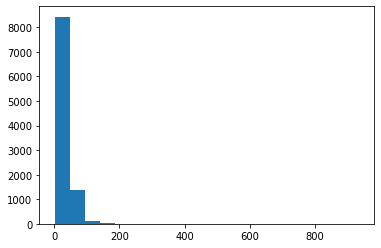

In [ ]:
length = [len(text) for text in tokenized_texts]
print("Nombre de phrases par texte en moyenne : %.1f" % (np.mean(length)))
plt.hist(length, bins=20)
plt.show()

Nombre de mots par phrase en moyenne :  32.60896117086382


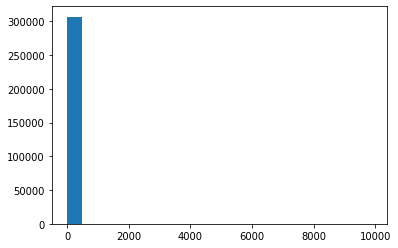

In [ ]:
length = [len(sentence) for text in tokenized_texts for sentence in text]
print("Nombre de mots par phrase en moyenne : ", np.mean(length))
plt.hist(length, bins=20)
plt.show()

### Padding des mots
Même nombre de mots par phrase

In [ ]:
n_classes = len(np.unique(dataset.objective)) # nb classes
n_sentences = 15
n_words = 30

In [ ]:
# meme nombre de mots par phrase : nombre de mots par phrase = 50
X = [pad_sequences(tokenized_sentence,
                  maxlen=n_words,
                  truncating="pre",
                  padding="pre", # on ajoute les tokens de padding au début du texte ne pas brouiller le dernier état caché du RNN
                  value=pad_id) for tokenized_sentence in tokenized_texts]

### Padding des phrases 
Même nombre de phrases par document

In [ ]:
# il faut avoir le même nombre de phrases par document (texte)
# ajouter un vecteur de zeros au début de chaque document
def pad_documents(documents, max_vects=n_sentences, vect_length=n_words):
    for i in range(len(documents)):
        nb_vects = len(documents[i])
        n_missing = nb_vects - max_vects
        if n_missing < 0:
            documents[i] = np.append((- n_missing) * [np.zeros(vect_length, dtype='int32')], documents[i], axis=0)
        elif n_missing > 0:
            documents[i] = documents[i][-max_vects:]
    return documents

In [ ]:
pad_texts = pad_documents(X, max_vects=n_sentences, vect_length=n_words)
pad_texts = np.asanyarray(pad_texts)
pad_texts.shape

(10000, 15, 30)

### Encodage des variables à prédire

In [ ]:
# Recoder les variables cibles en vecteurs de 0 et 1
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(dataset.objective).reshape(-1, 1)).toarray()
y.shape

(10000, 4)

# Classification des documents en utilisant HAN 


## Couches du modèle 


*   ***WSAttention :*** couche d'attention des mots et des phrases
*   ***WordEncoder :*** couche d'encodage des mots de chaque phrase d'un texte
*   ***SentenceEncoder :*** couche d'encodage des phrases d'un texte



In [ ]:
#### Word-Sentence Attention Layer
class WSAttention(k.layers.Layer):
    def __init__(self, context_vector_len):
        super(WSAttention, self).__init__()
        self.init = initializers.get('normal')
        self.context_vector_len = context_vector_len
    
    def build(self, input_shape):
        super(WSAttention, self).build(input_shape)        
        # Add a weights for the attention layer
        self.W = K.variable(self.init((input_shape[-1], self.context_vector_len)), name='W')
        self.b = K.variable(self.init((self.context_vector_len,)), name='bias')
        self.u = K.variable(self.init((self.context_vector_len, 1)), name='context_vector')

    def call(self, inputs, n_sentences):
        u_i = k.activations.tanh(K.dot(inputs, self.W) + self.b) # can be replaced by a Dense Layer
        uiu = K.dot(u_i, self.u)
        if len(inputs.shape) == 3 :# Words Attention
            uiu = K.squeeze(uiu, axis = -1)
            alpha_i = k.activations.softmax(uiu)
            # Multiply each input by its attention weights
            alpha_i = K.expand_dims(alpha_i)
            weighted_input = []
            output =[]
            for i in range(n_sentences): 
                weighted_input += [inputs[:,i,:] * alpha_i[:,i,:]]
                output += [K.sum(weighted_input, axis=0)]
            return tf.transpose(tf.convert_to_tensor(output),perm = [1,0,2])
        else: # Sentences Attention
            alpha_i = k.activations.softmax(uiu)
            # Multiply each input by its attention weights
            alpha_i = K.expand_dims(alpha_i)
            weighted_input = inputs* alpha_i
            output = K.sum(weighted_input, axis=1)
            return tf.convert_to_tensor(output)


#### Word Encoder
class WordEncoder(k.layers.Layer):
    def __init__(self, n_words, n_sentences, embedding_size, gru_dimension, vocabulary_size, vectors=None):
        super(WordEncoder, self).__init__()
        self.n_words = n_words
        self.n_sentences = n_sentences
        self.embedding_size = embedding_size
        self.gru_dimension = gru_dimension
        if vectors is not None: 
            self.embedding = Embedding(input_dim=vocabulary_size, 
                                          output_dim=embedding_size, 
                                          weights=[vectors],
                                          trainable=False)
        else: 
            self.embedding = Embedding(input_dim=vocabulary_size, 
                                          output_dim=embedding_size, 
                                          trainable=True)
        self.bi_gru = Bidirectional(GRU(gru_dimension, 
                                        bias_initializer="zeros",
                                        dropout=0.5,
                                        recurrent_initializer='glorot_uniform'))
        

    def call(self, inputs, batch_size=1):
        x = self.embedding(inputs)
        # la boucle ci-dessous aurait pu être remplacée par k.TimeDistributed layer - nous avons appris l'existence de ce layer hier seulement, faute de temps nous ne pourrons pas l'implémenter
        h_bi_text = []
        for i in range(self.n_sentences): # Each sentence of a given text must be passed through the Word Encoder layer
            reshaped_x = tf.squeeze(tf.slice(tf.convert_to_tensor(x), [0, i, 0, 0], [batch_size, 1, self.n_words, self.embedding_size]), axis=1)
            h_bi_text += [self.bi_gru(reshaped_x)]
        return tf.transpose(tf.convert_to_tensor(h_bi_text), perm=[1, 0, 2])

#### Sentence Encoder
class SentenceEncoder(k.layers.Layer):
    def __init__(self, gru_dimension):
        super(SentenceEncoder, self).__init__()
        self.bi_gru = Bidirectional(GRU(gru_dimension, 
                                        bias_initializer="zeros",
                                        dropout=0.5,
                                        recurrent_initializer='glorot_uniform'))
    def call(self, s_i):
        return self.bi_gru(s_i)

## Modèle HAN 

*   ***Entrées :*** un batch de textes, chaque texte est de dimension (nombre de phrases par texte, nombre de mots par phrase), donc la dimension des entrées du modèle est de (batch_size, nombre de phrases par texte, nombre de mots par phrase).
*   ***Couche d'encodage des mots (Word Encoder) :*** pour chaque phrase de chaque texte, on encode les mots les contenant.
*   ***Couche d'attention des mots de chaque phrase (Word Attention) :*** les mots encodés dans la précédente couche sont passés par une couche d'attention qui s'occupe de déterminer quels sont les mots les plus pertinents dans chaque phrases.
*   ***Couche d'encodage des phrases (Sentence Encoder) :*** chaque phrase de texte est encodée. A noter que les phrases à cette étape sont représentées par l'attention des mots les composant.
*   ***Couche d'attention des phrases (Sentence Attention) :*** les phrases précédement encodées sont passées par une couche d'attention pour déterminer la pertinence de celles-ci dans le texte. A noter que l'on parle de pertinence par rapport aux classes de prédiction, c-à-d quelles phrases détermineront si le texte appartient à la classe $c_i$.
*   ***Sortie :*** probabilité d'appartenance d'un texte donné à une classe $c_i$.



In [ ]:
class HAN(k.Model):
    def __init__(self, n_classes, embedding_size, n_sentences, n_words, gru_dimension, vocabulary_size, vectors=None):
        super(HAN, self).__init__()
        self.word_encoder = WordEncoder(n_words, n_sentences, embedding_size, gru_dimension, vocabulary_size, vectors)
        self.word_attention = WSAttention(context_vector_len=2*gru_dimension)
        self.sentence_encoder = SentenceEncoder(gru_dimension)
        self.sentence_attention = WSAttention(context_vector_len=2*gru_dimension)
        self.logits = Dense(units=n_classes, activation='softmax', name='Classification_Layer')
    
    def call(self, sentences): # sentences shape : (batch, n_sentences, n_words)
        h_we = self.word_encoder(sentences, sentences.shape[0]) # h_we shape : (batch, n_sentences, n_words, gru_dimension)
        s_i = self.word_attention(h_we, n_sentences) # s_i shape : (batch, n_sentences, n_words)
        h_se = self.sentence_encoder(s_i) # h_se shape : (batch, n_sentences, 2*gru_dimension)
        v = self.sentence_attention(h_se, n_sentences) # v shape : (batch, n_sentences)
        return self.logits(v)


## Entraînement

### Préparation des données 

In [ ]:
# Dataset split into train - test sets
train_x, test_x, train_y, test_y = train_test_split(pad_texts, y, test_size=0.2) # 80/20
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(8000, 15, 30)
(2000, 15, 30)
(8000, 4)
(2000, 4)


In [ ]:
# Train set split into train - validation sets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1) # 90/10
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(7200, 15, 30)
(800, 15, 30)
(7200, 4)
(800, 4)


In [ ]:
# Convert dataset to Tensors
train_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_x)) # train text tensor shape :  7200 * 15 * 200
train_target = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_y)) # train target tensor shape :  7200 * 4
val_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(val_x)) # train text tensor shape :  800 * 15 * 200
val_target = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(val_y)) # train target tensor shape :  800 * 4

batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_target = train_target.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_target = val_target.shuffle(buffer_size=1024).batch(batch_size)

### Entraînement du modèle

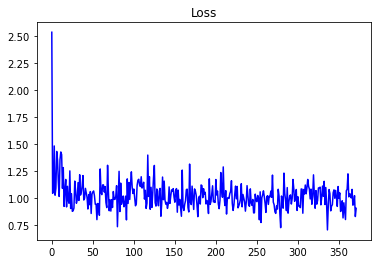

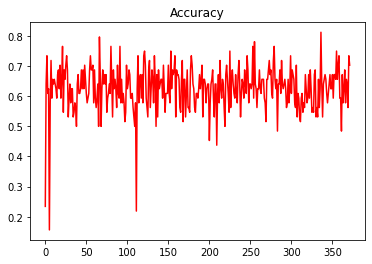

Epoch 4 Batch 32 Loss 0.903 Accuracy 0.70


KeyboardInterrupt: ignored

In [ ]:
# réglage des paramètres : 
embedding_size = 300
gru_dimension = 50

# HAN Model
han = HAN(n_classes=n_classes, embedding_size=embedding_size, n_sentences=n_sentences, n_words=n_words, gru_dimension=gru_dimension, vocabulary_size=len(vocabulary), vectors=np.array(vectors))

optimizer = k.optimizers.Adam(learning_rate=1e-3)
if d == 1:
    cce = k.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
else:
    cce = k.losses.BinaryCrossentropy(from_logits=True, reduction='none')
accuracy_metric = k.metrics.Accuracy()

def loss_function(y_target, y_pred):
    loss_ = cce(y_target, y_pred)
    return tf.reduce_mean(loss_)

def accuracy_score(y_target, y_pred):
    accuracy_metric.reset_states()
    pred = K.argmax(y_pred, axis=-1)
    target = K.argmax(y_target, axis=-1)
    accuracy_metric.update_state(target, pred)
    return accuracy_metric.result()

def train_step(x_batch, y_batch):
    loss, acc = 0, 0
    with tf.GradientTape() as tape:
        logits = han(x_batch)
        # Compute model loss
        loss += loss_function(y_batch, logits)
        acc += accuracy_score(y_batch, logits)
    batch_loss = loss
    batch_accuracy = acc
    grads = tape.gradient(loss, han.trainable_weights)
    optimizer.apply_gradients(zip(grads, han.trainable_weights))
    return batch_loss, batch_accuracy

epochs = 7
# Iterate over epochs.
loss, acc = [], []
for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset
    for step, (x_batch_train, y_batch_train) in enumerate(zip(train_dataset, train_target)):
        batch_loss, batch_accuracy = train_step(x_batch_train, y_batch_train)
        loss.append(batch_loss)
        acc.append(batch_accuracy)

        if step % 16 == 0 or step == 0:
            clear_output()
            plt.plot(loss, color="blue")
            plt.title("Loss")
            plt.show()
            plt.plot(acc, color="red")
            plt.title("Accuracy")
            plt.show()
            print('Epoch %d Batch %d Loss %.3f Accuracy %.2f' % (epoch + 1, step, batch_loss.numpy(), batch_accuracy.numpy()))
han.save_weights("han.weights")

In [ ]:
# Résumé du nombre de paramètres du modèle
han.summary()

## Tests

In [ ]:
# Utilisation du modèle

# preparer le texte : encoder les mots + padding des mots + padding des phrases
def prepare_text(text):
    tokenized_text = [[dictionnary.get(token.lower(), oov_id) for token in wordpunct_tokenize(sentence)] for sentence in sent_tokenize(text)]
    padded_words = [pad_sequences(tokenized_text, maxlen=n_words, truncating="pre", padding="pre", value=pad_id)]
    pad_text = pad_documents(padded_words, max_vects=n_sentences, vect_length=n_words)
    return np.asanyarray(pad_text)

# passer le texte par le modèle, retourne les logits
def document_classif(text):
    text = tf.expand_dims(tf.convert_to_tensor(text), axis=0)
    return tf.squeeze(han(text)).numpy()

# prepared_text = prepare_text(text)
# print(prepared_text.shape)
print(test_x.shape)
print("La classification peut prendre pas mal de temps s'il y a beaucoup d'exemples à tester.")
res = [document_classif(text) for text in test_x]
print(np.asanyarray(res).shape)

In [ ]:
from sklearn.metrics import accuracy_score as accuracy_sc

true = K.argmax(test_y, axis=-1)
pred = K.argmax(np.asanyarray(res), axis=-1)

print("Taux de réussite global sur le jeu de test : %.2f " % (accuracy_sc(y_true=true, y_pred=pred)))

# CNN et RNN

## Préparation des données

In [ ]:
from nltk.tokenize import wordpunct_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

coded_texts = [[dictionnary.get(i, pad_id) for i in wordpunct_tokenize(text)] for text in dataset.text]

equal_tokens_lists = pad_sequences(coded_texts , maxlen = 200, padding='post', truncating='pre', value = pad_id)
equal_tokens_lists.shape

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Recoder les variables cibles en vecteurs de 0 et 1
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(dataset.objective).reshape(-1, 1)).toarray()
n_classes=y.shape[1]
y.shape

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(equal_tokens_lists, y, test_size=.2, random_state=42)

## Classification des documents en utilisant un CNN


In [ ]:
# Document classification with CNN
import tensorflow.keras as k
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dropout, Concatenate, Embedding, Dense

def build_cnn(n_classes, n_words, vocabulary_length, filter_sizes, nb_conv_layers, vectors=None):
    input_layer = Input(shape = (n_words,))
    if vectors is not None:
        embedding_layer = Embedding(input_dim=vocabulary_length, output_dim=300, weights=[vectors], trainable=False)(input_layer)
    else:
        embedding_layer = Embedding(input_dim=vocabulary_length, output_dim=300, trainable=True)(input_layer)
    pool_layers = []
    for i in range(nb_conv_layers) :
        conv_layer = Conv1D(filters = 100, kernel_size = filter_sizes[i], activation='tanh')(embedding_layer)
        pool_layer = GlobalMaxPooling1D()(conv_layer)
        pool_layers.append(pool_layer)
    concat_layer = Concatenate(axis = 1)(pool_layers)
    dropout_layer = Dropout(.5, input_shape = (128,))(concat_layer)
    output_layer = Dense(n_classes, activation = 'softmax')(dropout_layer)
    return k.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
if d == 1:
    filter_sizes = [2, 3]
    nb_conv_layers = 2
else:
    filter_sizes = [2, 3, 4, 5]
    nb_conv_layers = 4


# Instanciation du modèle
cnn = build_cnn(n_classes=n_classes, n_words=200, vocabulary_length=len(vocabulary), filter_sizes=filter_sizes, nb_conv_layers=nb_conv_layers, vectors=np.array(vectors))

# Compilation du modèle
cnn.compile(optimizer='adam', loss="categorical_crossentropy",  metrics=["acc"])

# Affichage des paramètres du modèle
cnn.summary()

In [ ]:
# Entraînement
cnn.fit(x_train, y_train, epochs=20, verbose=1, batch_size=50, validation_split=.1)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(x_test), axis=1)
print("Accuracy on test data: %.4f" % accuracy_score(np.argmax(y_test, axis=1), y_pred))

## Classification des documents en utilisant un RNN

In [ ]:
# Document classification with RNN
from tensorflow.keras.layers import GRU, Input, Embedding, Dropout, Dense

def build_rnn(n_classes, n_words, vocabulary_length, vectors, gru_dimension):
    input_layer = Input(shape = (n_words,))
    if vectors is not None:
        embedding_layer = Embedding(input_dim=vocabulary_length, output_dim=300, weights=[vectors], trainable=False)(input_layer)
    else:
        embedding_layer = Embedding(input_dim=vocabulary_length, output_dim=300, trainable=True)(input_layer)
    gru_layer = GRU(gru_dimension, recurrent_initializer="orthogonal", bias_initializer="ones", dropout=0.2 )(embedding_layer)
    dropout_layer = Dropout(.5)(gru_layer)
    output_layer = Dense(n_classes, activation = 'softmax')(dropout_layer)
    return k.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Instanciation du modèle
rnn = build_rnn(n_classes=n_classes, n_words=200, vocabulary_length=len(vocabulary), vectors=np.array(vectors), gru_dimension = 50)

# Compilation du modèle
rnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Affichage du nombre de paramètres du modèle par couche
rnn.summary()

In [ ]:
# Entraînement
rnn.fit(x=x_train, y=y_train, batch_size=80, validation_split=0.33, epochs=20, verbose=1)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = np.argmax(rnn.predict(x_test), axis=1)
print("Accuracy on test data: %.4f" % accuracy_score(np.argmax(y_test, axis=1), y_pred))